## Gait Video Study
### SHAP-based feature importance for Task generalization framework
For local interpretation explanations, see https://www.kdnuggets.com/2019/12/interpretability-part-3-lime-shap.html

For installation, run:
* !pip install --upgrade setuptools
* !conda install -c conda-forge shap

For running this code, we would need 'config path' for the best task gen model containing the "saved_model_path" as the best task gen model's directory 

In [41]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import gait_data_loader
reload(gait_data_loader)
from ml_utils import task_gen_DLtrainer, DLutils, CNN1d_model, TCN_model, LSTM_model, GRU_model, RNN_model, MULTISCALE_RESNET_model, RESNET_model
reload(task_gen_DLtrainer)
reload(DLutils)
reload(CNN1d_model)
reload(TCN_model)
reload(LSTM_model)
reload(GRU_model)
reload(RNN_model)
reload(RESNET_model)
reload(MULTISCALE_RESNET_model)
from ml_utils.DLutils import set_random_seed
from ml_utils.task_gen_DLtrainer import GaitTrainer
from ml_utils.CNN1d_model import CNN1D
from ml_utils.TCN_model import TCN
from ml_utils.LSTM_model import LSTM
from ml_utils.GRU_model import GRU
from ml_utils.RNN_model import RNN
from ml_utils.MULTISCALE_RESNET_model import MSResNet
from ml_utils.RESNET_model import ResNet
import shap

In [42]:
#Config path for the best task gen model containing the "saved_model_path" as the 
#best model's directory 
config_path = ".\config_files\config_template_task_gen_shap_cnn.json"

#Set up vars for parsing
hyperparameter_grid = {}
parameter_dict = {}

#Load config
with open(config_path) as f: 
    config_data = f.read()

config = json.loads(config_data)

#Parse through imported dictionary
for key, value in config.items():
    if 'param_' in key:
        pkey = key.replace("param_", "")
        if 'optimizer' in pkey:
            op = []
            for optim_string in value:
                op.append(optims[optim_string])
            hyperparameter_grid[pkey] = op
        else:
            hyperparameter_grid[pkey] = value
    else:
        parameter_dict[key] = value      

In [43]:
trainer = GaitTrainer(parameter_dict, hyperparameter_grid, config_path)
#Initial setup for SHAP for Task Generalization 
trainer.task_gen_shap_initial_setup()

Original number of subjects in training and test sets: 32 26
Subjects in test set, which are not in training set
[403]
Subjects in training set, which are not in test set
[312, 102, 112, 113, 115, 123, 124]
Number of subjects in training and test sets after reduction: 25 25
Training frame count mean:  tensor(41.3294, dtype=torch.float64)
Training frame count standard deviation:  tensor(9.9662, dtype=torch.float64)
Normalized training data's mean: tensor(-3.3835e-16, dtype=torch.float64)
Normalized training data's standard deviation: tensor(1.0000, dtype=torch.float64)
save path:  C:\Users\Rachneet Kaur\Box\Gait Video Project\DLResults\WtoWT/CNN1D\cnn_try_task_gen_2021_05_30-00_59_35_743521/


In [44]:
trainer.best_model, trainer.X_sl_test, trainer.Y_sl_test

(<class 'skorch.net.NeuralNet'>[initialized](
   module_=CNN1D(
     (pos_encoding_layer): PositionalEncoder()
     (cnn_network): Sequential(
       (0): ConvBlock(
         (conv1): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
         (batch_norm_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU()
         (dropout_layer): Dropout(p=0.3, inplace=False)
         (convblock_net): Sequential(
           (0): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
           (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU()
           (3): Dropout(p=0.3, inplace=False)
         )
       )
       (1): ConvBlock(
         (conv1): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
         (relu): ReLU()
         (dropout_layer): Dropout(p=0, inplace=False)
         (convblock_net): Sequential(
           (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
           (1): ReLU()
      

In [30]:
#Rearranging the training data to fit the SHAP requirements 
train_body_coords = [trainer.X_sl_train[index]['body_coords'] for index in range(len(trainer.X_sl_train))]
train_body_coords = torch.stack(train_body_coords) 

train_frame_count = [trainer.X_sl_train[index]['frame_count'] for index in range(len(trainer.X_sl_train))]
train_frame_count = torch.stack(train_frame_count)

train_data = [train_body_coords, train_frame_count]
print ('Train data stats: ', len(train_data), train_data[0].shape, train_data[1].shape)

Train data stats:  2 torch.Size([1008, 20, 36]) torch.Size([1008])


### Checks on the loaded model

In [66]:
# print (trainer.best_model.forward({'body_coords': train_body_coords, 'frame_count': train_frame_count}))
# print (trainer.best_model.module(train_body_coords, train_frame_count))
# print (trainer.best_model.module_(train_body_coords, train_frame_count))

tensor([[ 0.1965,  0.3121, -0.0349],
        [ 0.2049,  0.3093, -0.0312],
        [ 0.2068,  0.3105, -0.0237],
        ...,
        [ 0.2133,  0.3214, -0.0223],
        [ 0.2345,  0.2954, -0.0337],
        [ 0.2080,  0.3093, -0.0246]])
tensor([[-0.1353,  0.0759, -0.2656],
        [-0.1504,  0.1076, -0.2681],
        [-0.1255,  0.0788, -0.2465],
        ...,
        [-0.1072,  0.0545, -0.2633],
        [-0.1598,  0.0891, -0.2922],
        [-0.1998,  0.0884, -0.2925]], grad_fn=<AddmmBackward>)
tensor([[ 0.1965,  0.3121, -0.0349],
        [ 0.2049,  0.3093, -0.0312],
        [ 0.2068,  0.3105, -0.0237],
        ...,
        [ 0.2133,  0.3214, -0.0223],
        [ 0.2345,  0.2954, -0.0337],
        [ 0.2080,  0.3093, -0.0246]], grad_fn=<AddmmBackward>)


In [83]:
# trainer.best_model.module.state_dict()['cnn_network.0.batch_norm_layer.weight']

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [84]:
# trainer.best_model.module_.state_dict()['cnn_network.0.batch_norm_layer.weight']

tensor([0.9991, 1.0011, 1.0005, 1.0003, 0.9995, 1.0007, 1.0004, 1.0001, 1.0011,
        0.9999, 1.0001, 0.9996, 1.0014, 0.9993, 0.9998, 1.0003, 1.0005, 1.0009,
        0.9995, 0.9997, 1.0009, 0.9994, 1.0006, 0.9988, 1.0004, 0.9995, 1.0000,
        1.0003, 0.9991, 1.0015, 1.0009, 0.9999, 1.0005, 1.0005, 1.0007, 1.0015,
        1.0013, 1.0003, 0.9997, 1.0005, 1.0005, 0.9993, 1.0005, 1.0000, 0.9996,
        1.0001, 1.0014, 1.0014, 1.0002, 0.9998, 1.0008, 1.0003, 0.9989, 1.0001,
        1.0012, 0.9989, 0.9998, 1.0009, 0.9996, 1.0005, 0.9993, 0.9996, 1.0012,
        0.9994])

### Back to computing SHAP values

In [67]:
#Rearranging the training data to fit the SHAP requirements 
train_body_coords = [trainer.X_sl_train[index]['body_coords'] for index in range(len(trainer.X_sl_train))]
train_body_coords = torch.stack(train_body_coords) 

train_frame_count = [trainer.X_sl_train[index]['frame_count'] for index in range(len(trainer.X_sl_train))]
train_frame_count = torch.stack(train_frame_count)

train_data = [train_body_coords, train_frame_count]
print ('Train data stats: ', len(train_data), train_data[0].shape, train_data[1].shape)

#SHAP Deep Explainer for CNN
explainer = shap.DeepExplainer(trainer.best_model.module_, train_data)

Train data stats:  2 torch.Size([1008, 20, 36]) torch.Size([1008])


In [68]:
#Rearranging the testing data to fit the SHAP requirements 
test_body_coords = [trainer.X_sl_test[index]['body_coords'] for index in range(len(trainer.X_sl_test))]
test_body_coords = torch.stack(test_body_coords)

test_frame_count = [trainer.X_sl_test[index]['frame_count'] for index in range(len(trainer.X_sl_test))]
test_frame_count = torch.stack(test_frame_count)

test_data = [test_body_coords, test_frame_count]
print ('Test data stats: ', len(test_data), test_data[0].shape, test_data[1].shape)

#Running the SHAP explainer for test set
shap_values = explainer.shap_values(test_data)

Test data stats:  2 torch.Size([1016, 20, 36]) torch.Size([1016])


In [69]:
#Stats for the SHAP values 
print (len(shap_values)) #Since we have 3 classes 
print (len(shap_values[0]), len(shap_values[1]), len(shap_values[2])) 
#Since we have 2 types of inputs, namely body coordinates and frame count 
print (shap_values[0][0].shape) #Since body coords is 20*36

3
2 2 2
(1016, 20, 36)


In [70]:
#Postprocessing the SHAP values to reshape to num_classes x num_samples x num_features i.e. across 
#the body coords, we would need to average the 20 SHAP values for 20 time steps to one SHAP value 
#per sample and feature. 
classes = [0, 1, 2]
shaps_feature_wise = []
for class_index in classes:
    #For body coords, averaging across the 20 time steps to have one SHAP value 
    #for each instance, feature pair
    shap_body_coords = shap_values[class_index][0].mean(axis = 1)
    #For frame count
    shap_frame_count = shap_values[class_index][1].reshape(-1, 1)
    shap_feature_wise = np.concatenate((shap_body_coords, shap_frame_count), axis = 1)
    shaps_feature_wise.append(shap_feature_wise) 

In [71]:
#As the SHAP values for body coords are now one feature per sample, and thus we need to average 
#the original test set body coords values as well to have one feature per sample 
Xtest_feature_wise = np.concatenate((test_data[0].mean(axis = 1), test_data[1].reshape(-1, 1)), axis = 1)
order = ['Right Hip', 'Right Knee', 'Right Ankle', 'Left Hip', 'Left Knee', 'Left Ankle', 'Left Big Toe', 'Left Little Toe', \
         'Left Heel', 'Right Big Toe', 'Right Little Toe', 'Right Heel']
feature_names = [o + '-'+ y for o in order for y in ['x', 'y', 'z']] + ['Frame Count']
Xtest_feature_wise_df = pd.DataFrame(Xtest_feature_wise, columns= feature_names)

print (shaps_feature_wise[0].shape, Xtest_feature_wise_df.shape)

(1016, 37) (1016, 37)


## SHAP Vizualizations 

In [72]:
# init the JS visualization code
shap.initjs()

### Global feature importance Bar Plot 
### This has all 3 classes included in a single plot 

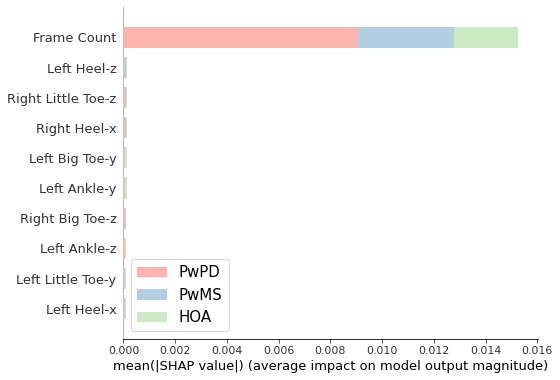

In [73]:
#Global feature importance Bar Plot 
#This has all 3 classes included in a single plot 
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise, features = Xtest_feature_wise_df, plot_type='bar', \
                  class_names= ['HOA', 'PwMS', 'PwPD'], max_display=10, show=False,  color=plt.get_cmap("Pastel1"))
f = plt.gcf()
plt.tight_layout()
plt.legend(fontsize = 15)
#All plots are saved to SHAPResults directory
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_bar.png', dpi = 350)

### Global feature importance Beeswarm plot
### We need 3 different plots for 3 classes in this case 

For HOA


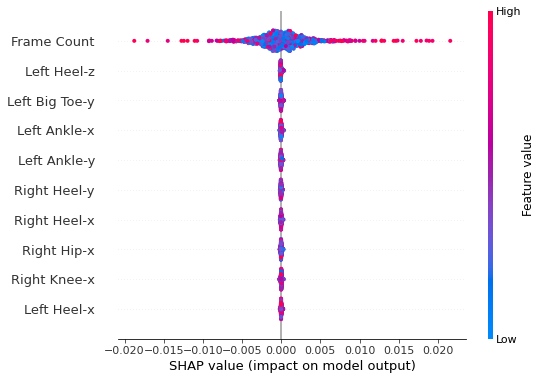

In [74]:
#Global feature importance Beeswarm plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_HOA.png', dpi = 350)

For PwMS


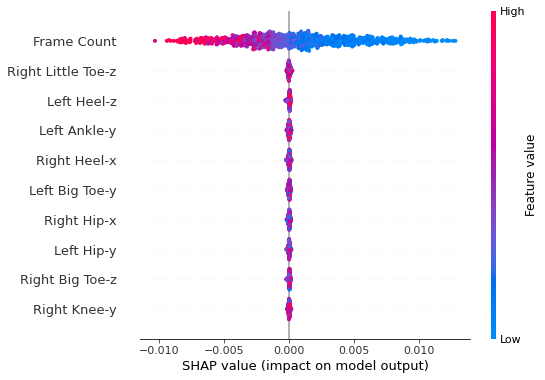

In [75]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwMS.png', dpi = 350)

For PwPD


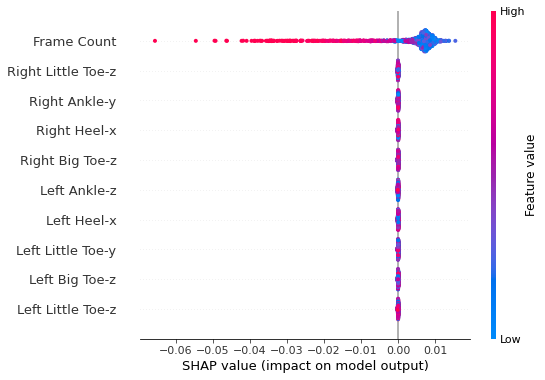

In [76]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwPD.png', dpi = 350)

### Global feature importance Violin plot
### We need 3 different plots for 3 classes in this case 

For HOA


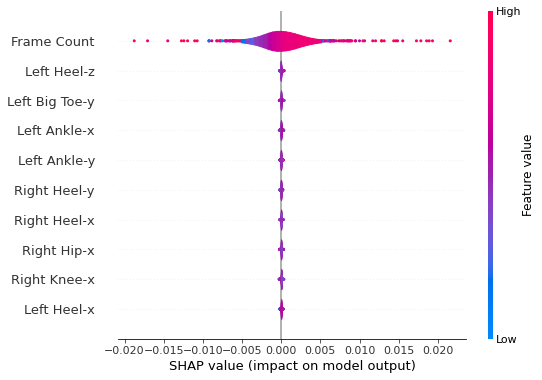

In [77]:
#Global feature importance Violin plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_HOA.png', dpi = 350)

For PwMS


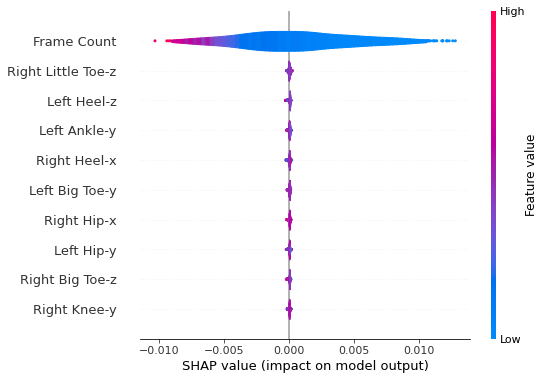

In [78]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwMS.png', dpi = 350)

For PwPD


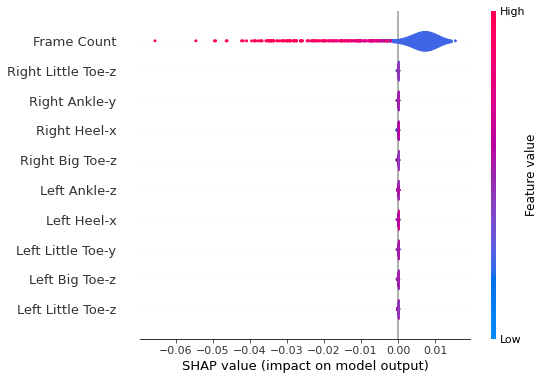

In [79]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwPD.png', dpi = 350)

### Local feature importance force plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance 

In [80]:
#Force plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
classes = [0, 1, 2]
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
out_names_ = ['HOA', 'PwMS', 'PwPD']
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])
print ('True PID: ', trainer.PID_sl_test[instance_to_explain])

for class_to_explain in classes:
# plot the explanation of the first prediction
    force_ = shap.force_plot(
        base_value=explainer.expected_value[class_to_explain],
        shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
        features=Xtest_feature_wise_df.iloc[instance_to_explain],
        feature_names=Xtest_feature_wise_df.columns,
        link="logit",
        out_names=out_names_[class_to_explain]
    )
    #This plot doesn't display but is directly saved at the specified path 
    shap.save_html('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
              '/shap_local_force_instance' + str(instance_to_explain) + '_' + out_names_[class_to_explain] + '.htm', force_)

#Display all features and SHAP values
#The table below the plot is the full list of features and their 
#SHAP additive weights.
#Display all features and SHAP values for all 3 classes 
df1=pd.DataFrame(data=shaps_feature_wise[0][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[0]).transpose().sort_values(by=0, ascending=True)
df2=pd.DataFrame(data=shaps_feature_wise[1][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[1]).transpose().sort_values(by=1, ascending=True)
df3=pd.DataFrame(data=shaps_feature_wise[2][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[2]).transpose().sort_values(by=2, ascending=True)
df=pd.concat([df1,df2,df3], axis = 1)
df.columns = ['HOA', 'PwMS', 'PwPD']
display(df.transpose())
#This first obvious difference is SHAP will output a seperate matrix 
#for each class prediction for the given input row. This means we have 
#3 plots to look at instead of just one. This is useful because a 
#regulator may be just as interested in why you made a decision as 
#they are in why you didn't make another.
#The units for force and decision plots are probabilities for predicting 
#the particular class for that instance vs. not that class 
#The class with the highest prediction probability is the predicted target

Expected values:  [ 0.21379691  0.30903584 -0.03394822]
True label:  tensor(0)
True PID:  tensor([212.])


,Frame Count,Right Knee-x,Left Ankle-y,Left Little Toe-x,Left Little Toe-z,Left Knee-z,Right Hip-x,Left Little Toe-y,Right Ankle-x,Left Ankle-x,...,Right Little Toe-x,Right Big Toe-y,Right Heel-x,Left Big Toe-y,Right Ankle-y,Right Big Toe-x,Left Hip-x,Right Hip-y,Left Heel-z,Right Heel-y
HOA,-0.001227,-0.000069,-0.000065,-0.000060,-0.000045,-0.000037,-0.000036,-0.000030,-0.000027,-0.000022,...,0.000023,0.000031,0.000032,0.000033,0.000033,0.000055,0.000058,0.000061,0.000067,0.000096
PwMS,0.000400,0.000085,0.000116,0.000007,0.000013,0.000018,0.000043,0.000009,0.000060,0.000057,...,-0.000023,-0.000030,-0.000049,-0.000086,-0.000066,-0.000143,-0.000046,-0.000057,-0.000122,-0.000057
PwPD,0.007308,0.000041,0.000022,0.000035,0.000059,0.000030,0.000004,0.000034,0.000047,0.000031,...,0.000011,-0.000024,-0.000044,-0.000046,-0.000087,-0.000072,-0.000032,-0.000022,-0.000056,-0.000048


### Local feature importance decision plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance only

Expected values:  [ 0.21379691  0.30903584 -0.03394822]
True label:  tensor(0)
For  HOA
For  PwMS
For  PwPD


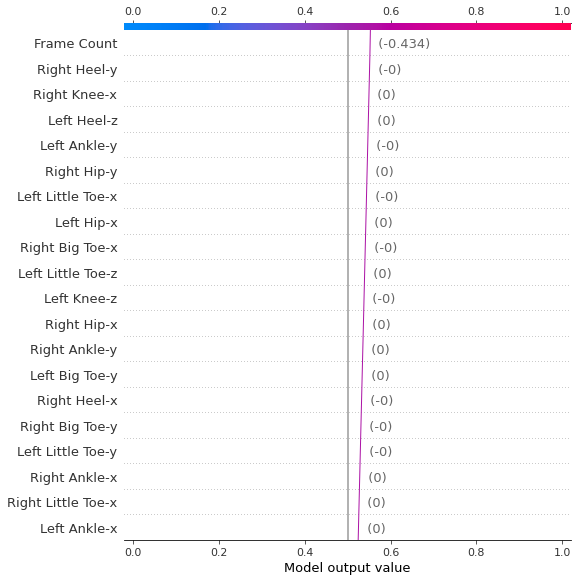

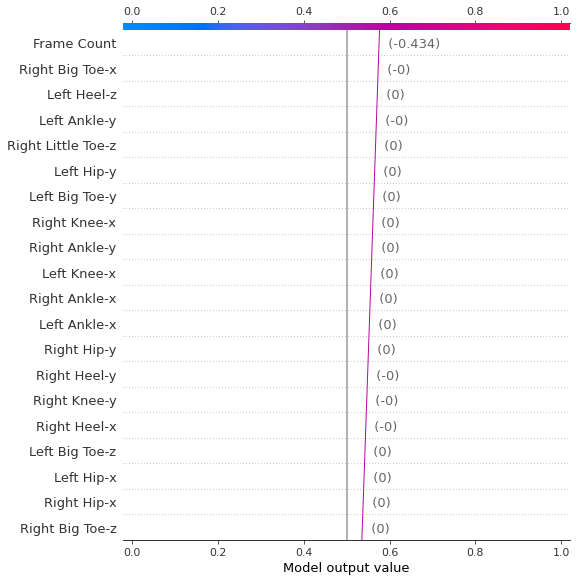

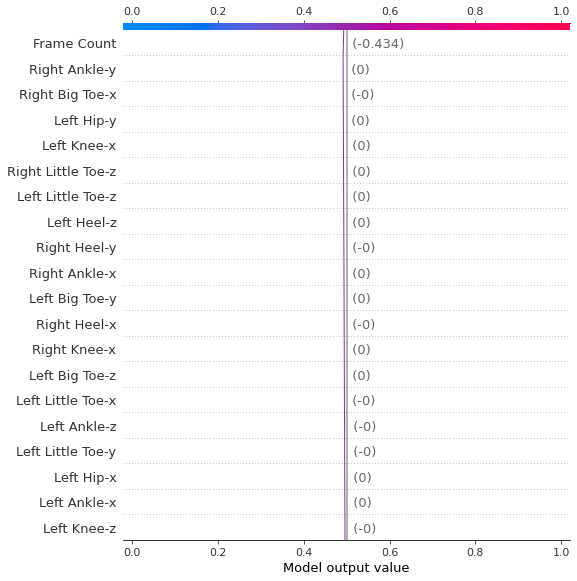

<Figure size 432x288 with 0 Axes>

In [81]:
##Decision plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

# We provide new_base_value as the cutoff probability for the classification mode
# This is done to increase the interpretability of the plot 
new_base_value=0

for class_to_explain in classes:
    # plot the explanation of the first prediction
    shap.decision_plot(
        base_value=explainer.expected_value[class_to_explain],
        shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
        features=Xtest_feature_wise_df.iloc[instance_to_explain],
        feature_names=Xtest_feature_wise_df.columns.to_list(),
        link="logit",
        new_base_value=0,
        show = False
    )
    f = plt.gcf()
    plt.figure()
    print ('For ', out_names_[class_to_explain])
    
    plt.tight_layout()
    f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
          '/shap_local_decision_instance' + str(instance_to_explain) + '_' + out_names_[class_to_explain] + '.png', dpi = 350)
    f.show()

### Local feature importance multioutput decision plot
### This plots all 3 classes in a single decision plot explaining a particular single instance only (basically merges all the 3 plots above)

In [85]:
## Important ##
## We would need to manually write the predicted probabilities for 3 classes from the three force plots generated for this 
#instance we need to explain 
prob_predictions_from_force_plot = [0.55, 0.58, 0.49]

#This function assigns legend to the multioutput decision plot with cohort name and it's
#corresponding prediction probability 
def class_labels():
    return [f'Class {out_names_[i]} ({prob_predictions_from_force_plot[i]})' for i in classes]

Expected values:  [ 0.21379691  0.30903584 -0.03394822]
True label:  tensor(0)
For all 3 classes in same plot: 


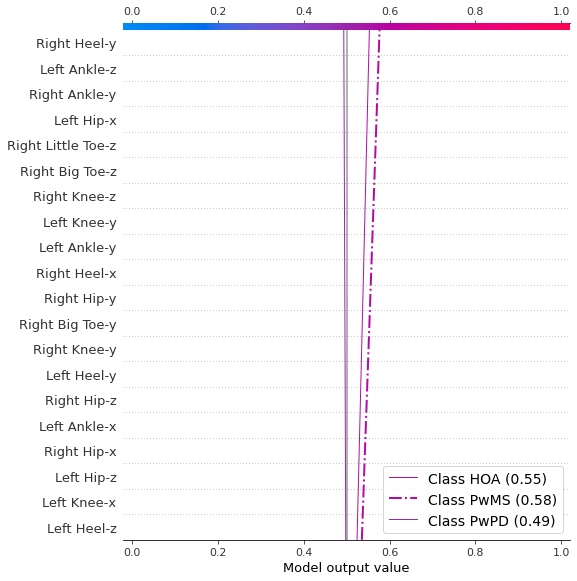

<Figure size 432x288 with 0 Axes>

In [86]:
##Decision plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

# We provide new_base_value as the cutoff probability for the classification mode
# This is done to increase the interpretability of the plot 
new_base_value=0

plt.rcParams['font.size'] = '14'

# plot the explanation of the first prediction
#Plotting all 3 cohort predictions on the same plot
shap.multioutput_decision_plot(
    base_values=list(explainer.expected_value),
    shap_values=shaps_feature_wise,
    row_index= instance_to_explain, #The instance we would like to explain 
    features=Xtest_feature_wise_df.iloc[instance_to_explain],
    feature_names=Xtest_feature_wise_df.columns.to_list(),
    link="logit", #To display the prediction probabilities on the plot
    new_base_value=0, #To have a vertical line at 0.5 for clear vizualization of predicted class 
    show = False,
    #Highlight the cohort with highest prediction probability
    highlight=[np.argmax(prob_predictions_from_force_plot)], 
    #Leged with cohort and coresponding prediction probability 
    legend_labels=class_labels(),
    legend_location='lower right'
)
f = plt.gcf()
plt.figure()
print ('For all 3 classes in same plot: ')

plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
      '/shap_local_multioutput_decision_instance' + str(instance_to_explain) + '.png', dpi = 350)
f.show()